**Задача**

В приложенных файлах вы увидите данные по прохождению студентами тестов на образовательной платформе. Такие данные могут быть использованы для построения персонализированных ИИ-ассистентов для поддержки обучения студента. На текущем этапе сосредоточимся на начальном этапе — сборе и подготовке данных.

Вам необходимо:
Используя библиотеку pandas (или аналоги), проанализировать как можно больше характеристик, влияющих на успеваемость студентов.

In [103]:
#Импортируем нужные библиотеки
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

## train.csv

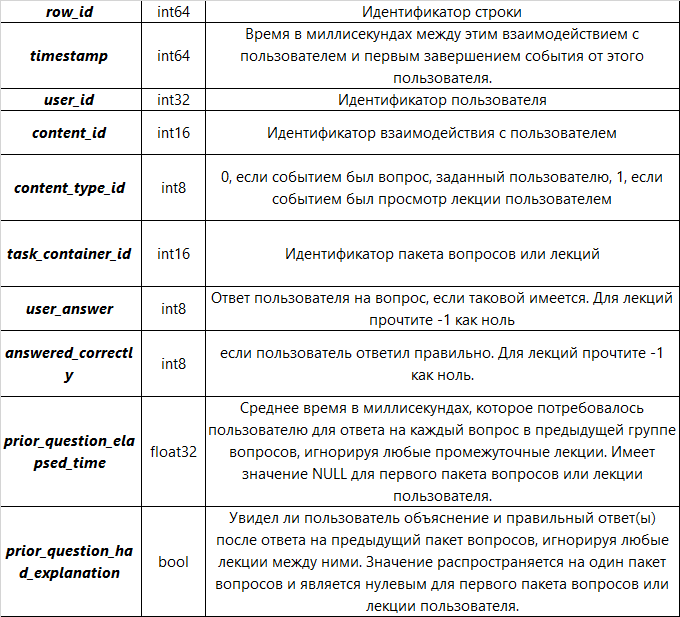

In [104]:
#В переменную записываем тип данных для последующей корректировки типов данных
dtype_train = {
    "row_id": "int64",
    "timestamp": "int64",
    "user_id": "int32",
    "content_id": "int16",
    "content_type_id": "int8",
    "task_container_id": "int16",
    "user_answer": "int8",
    "answered_correctly": "int8",
    "prior_question_elapsed_time": "float32",
    "prior_question_had_explanation": "boolean"
}

## questions.csv

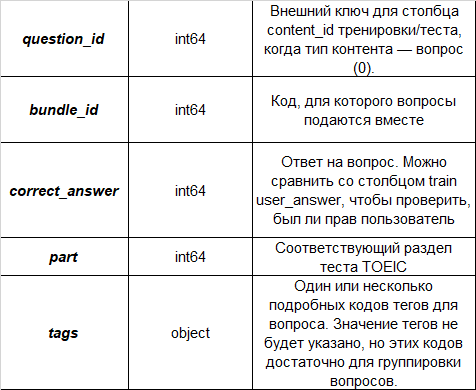

In [105]:
dtype_questions = {
    "question_id": "int64",
    "bundle_id": "int64",
    "correct_answer": "int64",
    "part": "int64",
    "tags": "object"
}

## lectures.csv

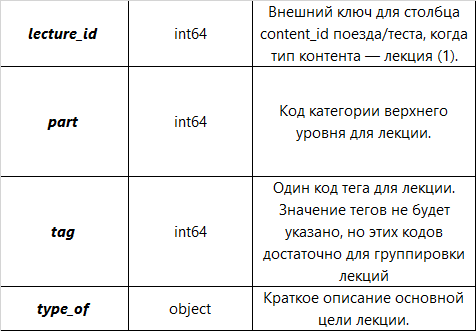

In [106]:
dtype_lectures = {
    "lecture_id": "int64",
    "part": "int64",
    "tag": "int64",
    "type_of": "object"
}

In [107]:
#Загружаю данные с google drive, из-за ошибок с паматью в Colab ограничиваю вывод 1 млн строк для файла train, для остальных ограничение не вводим
from google.colab import drive
drive.mount('/content/drive')
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Pandas (HW)/train-001.csv', nrows=1000000, dtype=dtype_train)
lectures = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Pandas (HW)/lectures.csv', dtype=dtype_lectures)
questions = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Pandas (HW)/questions.csv', dtype=dtype_questions)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [108]:
# Проверим сколько пропущенных значений для каждого id в датасете и заменим на ноль и False
train['prior_question_elapsed_time']=train['prior_question_elapsed_time'].fillna(0)
train['prior_question_had_explanation']=train['prior_question_had_explanation'].fillna(False)
train.isnull().sum()

,0
row_id,0
timestamp,0
user_id,0
content_id,0
content_type_id,0
task_container_id,0
user_answer,0
answered_correctly,0
prior_question_elapsed_time,0
prior_question_had_explanation,0


In [109]:
# Не требует корректировок
lectures.isnull().sum()

,0
lecture_id,0
tag,0
part,0
type_of,0


In [110]:
# Проверим сколько пропущенных значений для каждого id в датасете и заменим на ноль
questions['tags']=questions['tags'].fillna(0)
questions.isnull().sum()

,0
question_id,0
bundle_id,0
correct_answer,0
part,0
tags,0


## Определение успеваемости студентов от факторов
Для общей картины построим тепловую каруа корреляций для числовых признаков и на основе корреляций можно будет вычесть заведомо ложные связи.
Для начала соберем датафрейм основываясь на комментариях к задаче это разделение content_type_id на вопросы и лекции

In [111]:
#Фильтруем content_type_id по вопросам и лекциям и объеденяем с датафреймами questions и lectures
quest = train[train["content_type_id"] == 0].merge(questions, left_on="content_id", right_on="question_id", how="left")
lectг = train[train["content_type_id"] == 1].merge(lectures, left_on="content_id", right_on="lecture_id", how="left")
# Объеденяем в один датафрейм и сортируем по номеру строки
train = pd.concat([quest, lectг]).sort_values("row_id")

In [112]:
#Проверяем на наличие нулей далее он объеянсти отсутсвие корреляций между значениями
train.isnull().sum()

,0
row_id,0
timestamp,0
user_id,0
content_id,0
content_type_id,0
task_container_id,0
user_answer,0
answered_correctly,0
prior_question_elapsed_time,0
prior_question_had_explanation,0


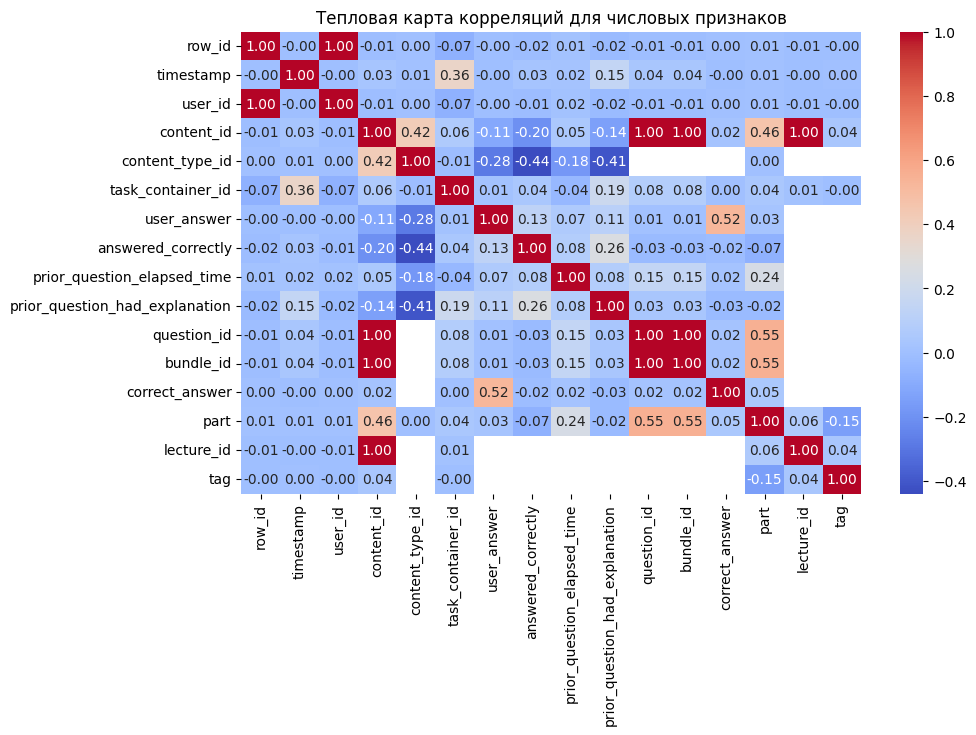

In [113]:
#Для построения используем библиотеки matplotlib и seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(train.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Тепловая карта корреляций для числовых признаков")
plt.show()


 Процент корректных ответов: 61.75%


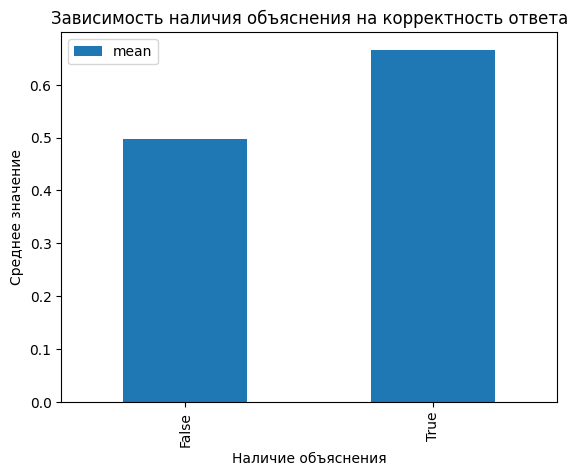


 Зависимости времени от корректности ответа: 0.08


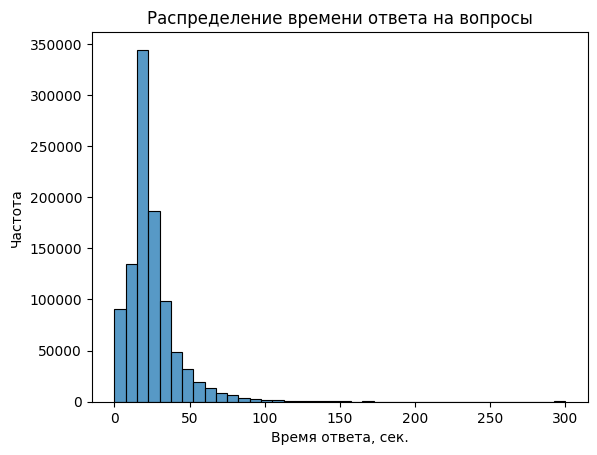

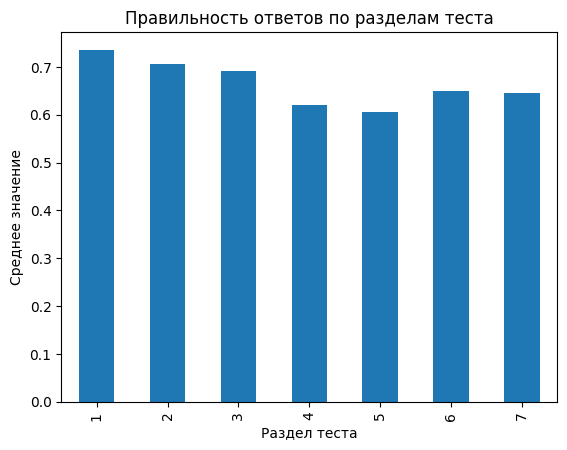

In [130]:
#Начнем с анализам по ответам
#1. Процент корректных ответов
correct_ans = train['answered_correctly'].mean()
print(f'\n Процент корректных ответов: {correct_ans * 100:.2f}%')
#2. Зависимость наличия объяснения на корректность ответа
explanation_ans = (train[train["content_type_id"] == 0].groupby("prior_question_had_explanation")["answered_correctly"].agg(["mean"]))
explanation_ans.plot(kind="bar")
plt.title("Зависимость наличия объяснения на корректность ответа")
plt.xlabel("Наличие объяснения")
plt.ylabel("Среднее значение")
plt.show()
#3. Зависимости времени от корректности ответа по карте корреляции 0.08 и построим график
time_correct = train[['prior_question_elapsed_time', 'answered_correctly']].corr().iloc[0, 1]
print(f'\n Зависимости времени от корректности ответа: {time_correct:.2f}')
sns.histplot(train['prior_question_elapsed_time'].dropna() / 1000, bins=40)
plt.title('Распределение времени ответа на вопросы')
plt.xlabel('Время ответа, сек.')
plt.ylabel('Частота')
plt.show()
#4. Зависмость по разделам тест, по среднему выделяется тесты 1, 2, 3
train[train["content_type_id"] == 0].groupby("part")["answered_correctly"].mean().plot(kind="bar")
plt.title("Правильность ответов по разделам теста")
plt.xlabel("Раздел теста")
plt.ylabel("Среднее значение")
plt.show()

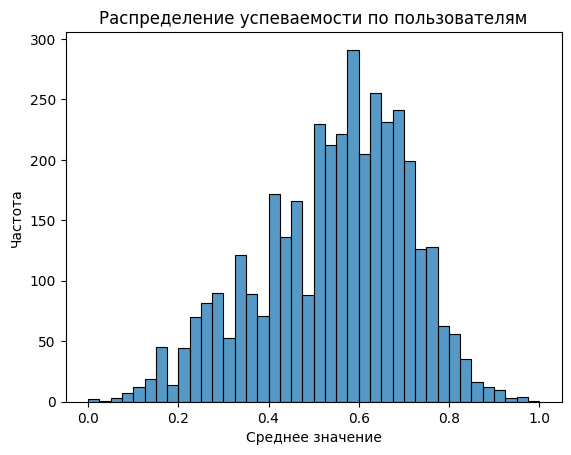

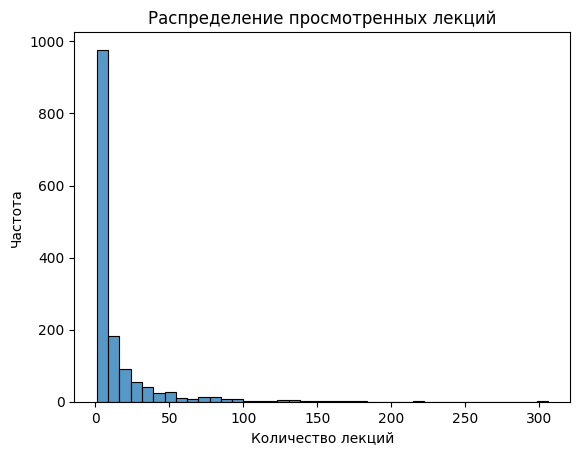

In [136]:
#Пользователи
#1. Распределение успеваемости по пользователям
sns.histplot(train[train["content_type_id"] == 0].groupby("user_id")["answered_correctly"].mean(),bins=40)
plt.title("Распределение успеваемости по пользователям")
plt.xlabel("Среднее значение")
plt.ylabel("Частота")
plt.show()
#2. Распределение просмотренных лекций
sns.histplot(train[train['content_type_id'] == 1].groupby('user_id').size(), bins=40)
plt.title("Распределение просмотренных лекций")
plt.xlabel("Количество лекций")
plt.ylabel("Частота")
plt.show()
